In [1]:
import pandas as pd
import wandb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

api = wandb.Api()

In [2]:
# Project is specified by <entity/project-name>
# tags = ['pfsp-fixedelo','symmetric','asymmetric','k=0']
tags = ["behind_only"]
history_dataframes = []
for tag in tags:
    training_runs = api.runs(
        "amar-research/safetyh",
        filters={"config.eval": False, "config.max_steps": 100000, "tags": tag},
    )

    for run in tqdm(training_runs, desc="Processing Training Runs"):
        ego_version = run.config["ego_version"]
        npc_version = run.config["npc_version"]
        history = run.scan_history()
        episodes = history.max_step
        tags = run.tags
        sampling = run.config["model_sampling"]

        history_dataframes.append(
            (
                run.history(
                    samples=episodes, x_axis="_step", pandas=(True), stream="default"
                ),
                tags,
                ego_version,
                npc_version,
                sampling,
            )
        )

Processing Training Runs: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


In [13]:
cum_eps_ego = [0]
cum_eps_npc = [0]
for i in range(1, max_ego_version + 1):
    cum_eps_ego.append(episode_dict["train_ego"][i] + cum_eps_ego[-1])

for i in range(1, max_npc_version + 1):
    cum_eps_npc.append(episode_dict["train_npc"][i] + cum_eps_npc[-1])

npc_elos = np.zeros((max_ego_version, cum_eps_ego[-1]))
ego_elos = np.zeros((max_npc_version, cum_eps_npc[-1]))

npc_sr = np.zeros((max_ego_version, cum_eps_ego[-1]))
ego_sr = np.zeros((max_npc_version, cum_eps_npc[-1]))

opponent_ego_elos = np.zeros((max_ego_version, cum_eps_ego[-1]))
opponent_npc_elos = np.zeros((max_npc_version, cum_eps_npc[-1]))

crashes = np.zeros((3, max_ego_version, 2))


for i in tqdm(range(1, max_ego_version + 1), desc="Concatenating NPC ELOs"):
    history = history_dict["train_ego"][i]
    episodes = episode_dict["train_ego"][i]
    start_idx = cum_eps_ego[i - 1]
    for idx, scan in tqdm(
        enumerate(history),
        leave=False,
        desc=f"Slicing from {start_idx} to {start_idx + episodes}",
        total=episodes,
    ):
        for j in range(1, i + 1):
            npc_elos[j - 1, start_idx + idx] = scan[f"rollout/model_{j - 1}_elo"]
            npc_sr[j - 1, start_idx + idx] = scan[f"rollout/model_{j - 1}_sr100"]
            opponent_ego_elos[j - 1, start_idx + idx] = scan[f"rollout/opponent_elo"]
            if "behind" in scan[f"rollout/spawn_config"]:
                crashes[0, i - 1, 1] += 1
                if scan["rollout/num_crashes"] == 1:
                    crashes[0, i - 1, 0] += 1
            elif "forward" in scan[f"rollout/spawn_config"]:
                crashes[1, i - 1, 1] += 1
                if scan["rollout/num_crashes"] == 1:
                    crashes[1, i - 1, 0] += 1
            elif "adjacent" in scan[f"rollout/spawn_config"]:
                crashes[2, i - 1, 1] += 1
                if scan["rollout/num_crashes"] == 1:
                    crashes[2, i - 1, 0] += 1

for i in tqdm(range(1, max_npc_version + 1), desc="Concatenating EGO ELOs"):
    history = history_dict["train_npc"][i]
    episodes = episode_dict["train_npc"][i]
    start_idx = cum_eps_npc[i - 1]
    for idx, scan in tqdm(
        enumerate(history),
        leave=False,
        desc=f"Slicing from {start_idx} to {start_idx + episodes}",
        total=episodes,
    ):
        for j in range(1, i + 1):
            ego_elos[j - 1, start_idx + idx] = scan[f"rollout/model_{j - 1}_elo"]
            ego_sr[j - 1, start_idx + idx] = scan[f"rollout/model_{j - 1}_sr100"]
            opponent_npc_elos[j - 1, start_idx + idx] = scan[f"rollout/opponent_elo"]
            if "behind" in scan[f"rollout/spawn_config"]:
                crashes[0, i - 1, 1] += 1
                if scan["rollout/num_crashes"] == 1:
                    crashes[0, i - 1, 0] += 1
            elif "forward" in scan[f"rollout/spawn_config"]:
                crashes[1, i - 1, 1] += 1
                if scan["rollout/num_crashes"] == 1:
                    crashes[1, i - 1, 0] += 1
            elif "adjacent" in scan[f"rollout/spawn_config"]:
                crashes[2, i - 1, 1] += 1
                if scan["rollout/num_crashes"] == 1:
                    crashes[2, i - 1, 0] += 1

Concatenating EGO ELOs: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


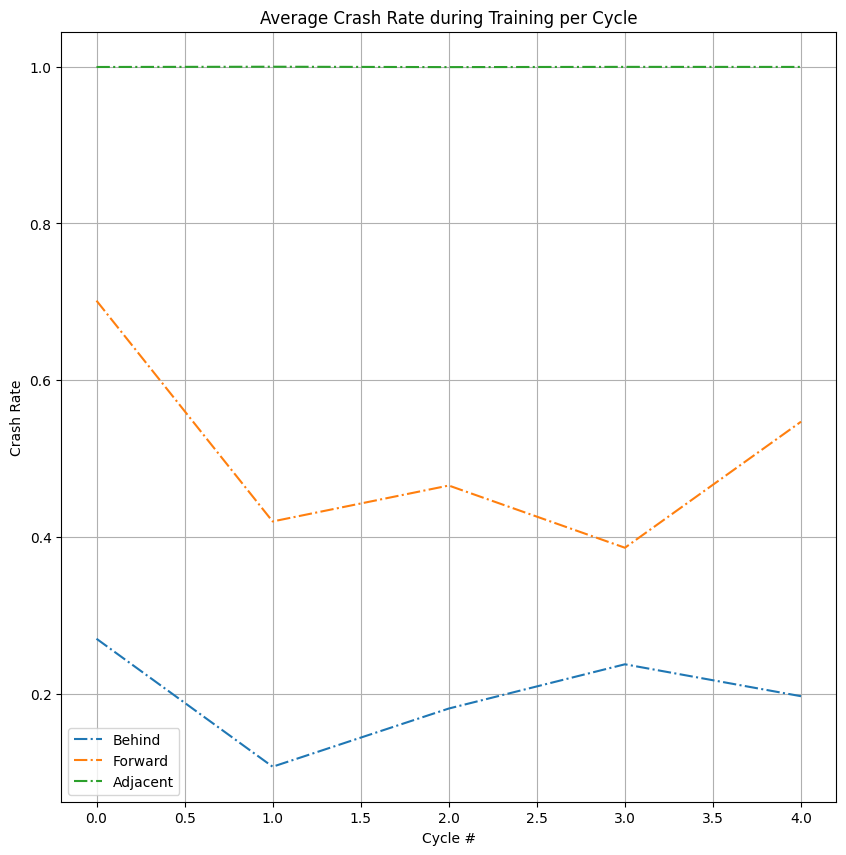

In [4]:
plt.figure(figsize=(10, 10))
plt.plot(crashes[0, :, 0] / crashes[0, :, 1], label="Behind", linestyle="-.")
plt.plot(crashes[1, :, 0] / crashes[1, :, 1], label="Forward", linestyle="-.")
plt.plot(crashes[2, :, 0] / crashes[2, :, 1], label="Adjacent", linestyle="-.")
plt.grid()
plt.legend()
plt.xlabel("Cycle #")
plt.ylabel("Crash Rate")
plt.title("Average Crash Rate during Training per Cycle")
plt.show()

0


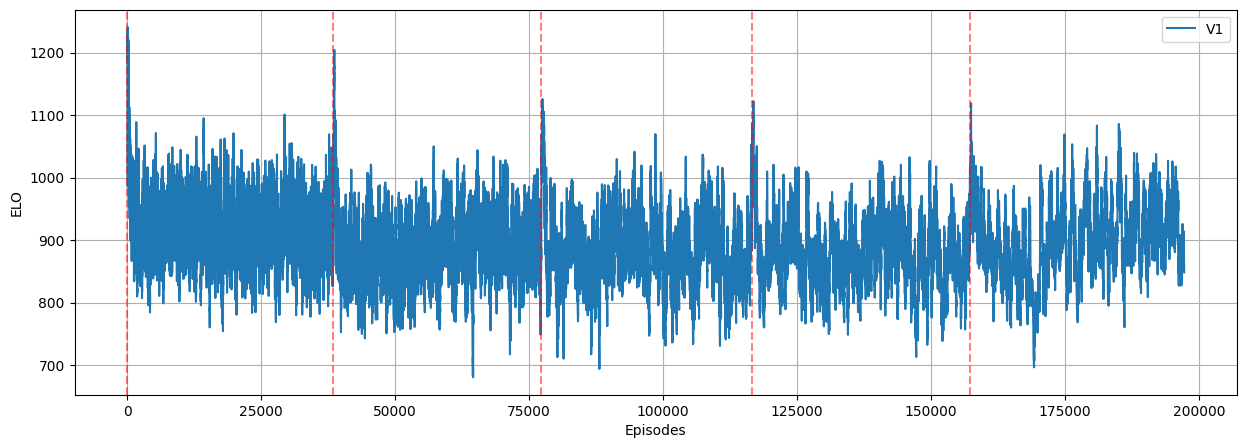

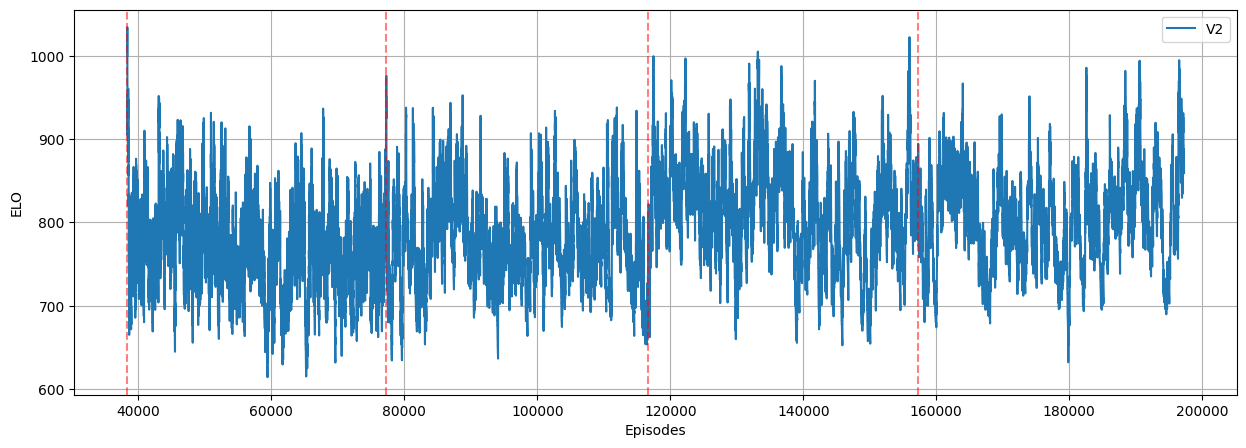

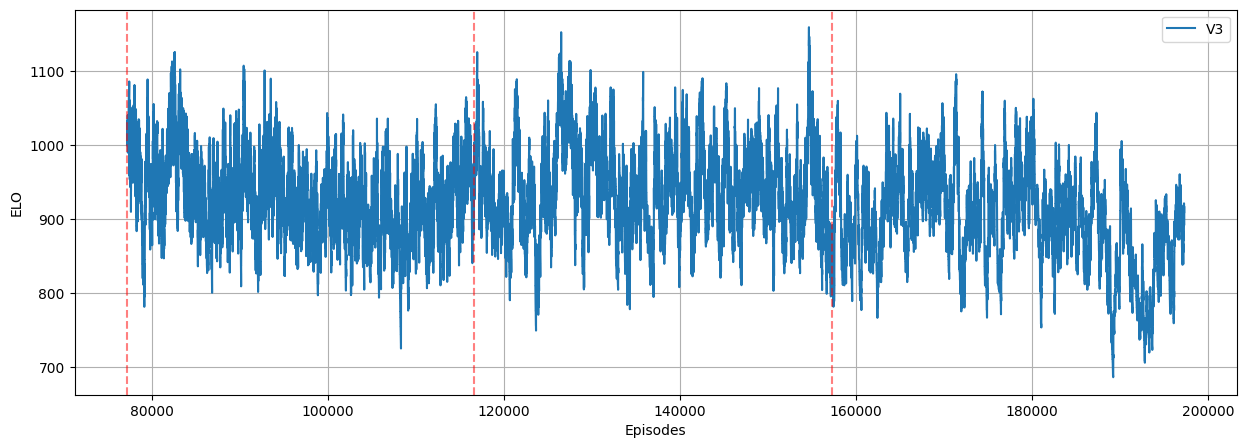

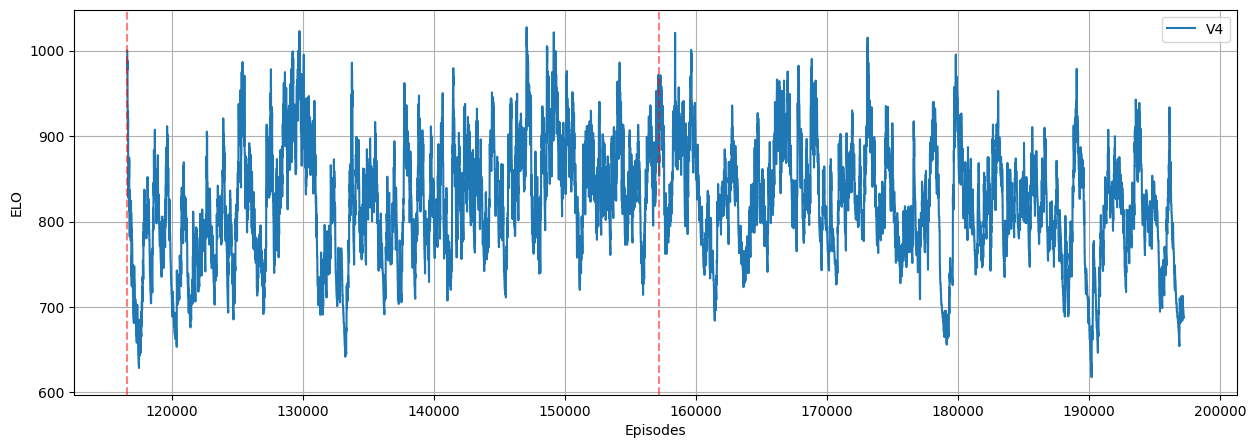

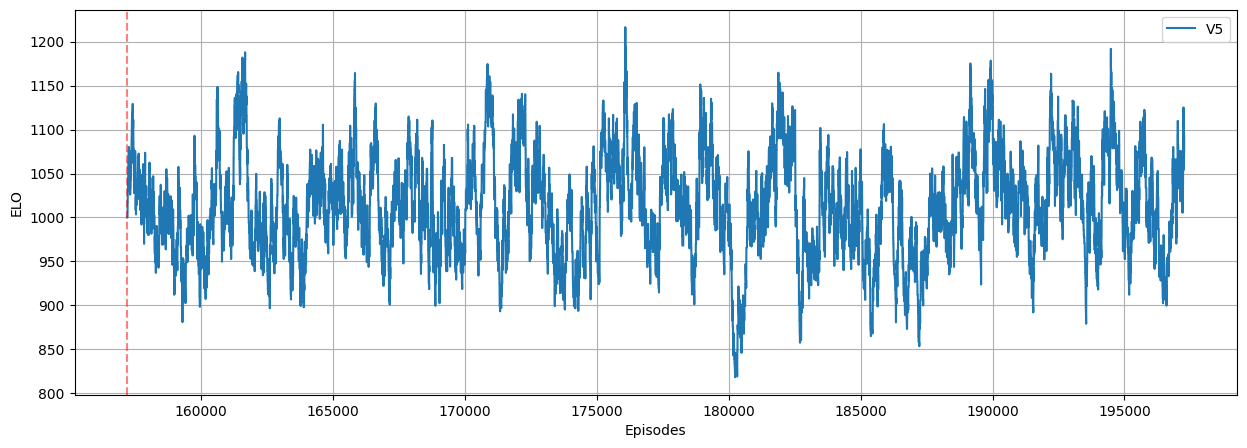

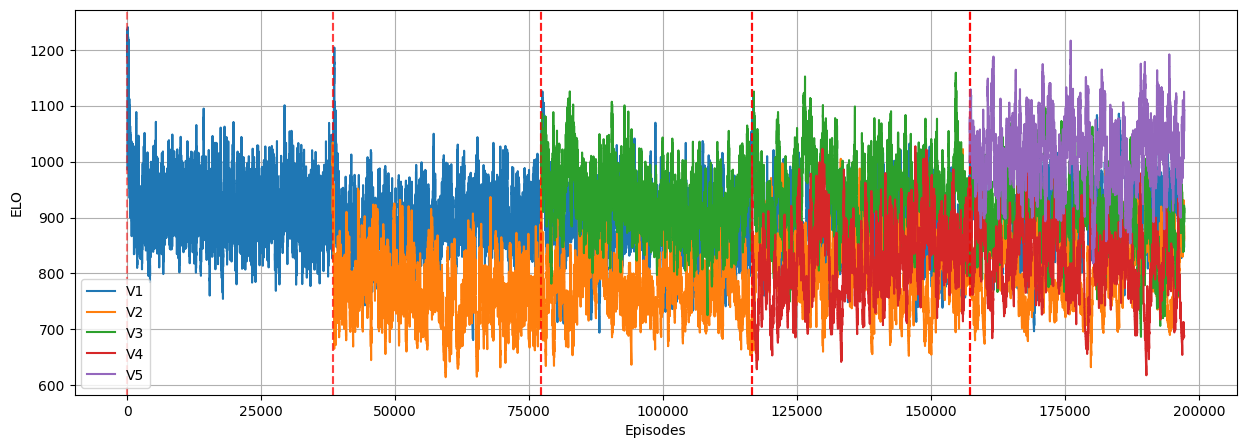

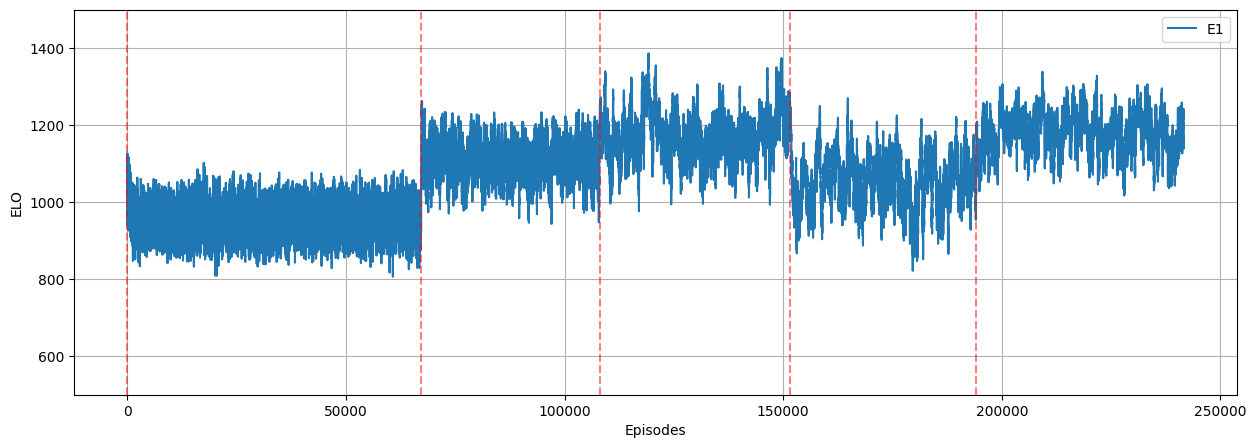

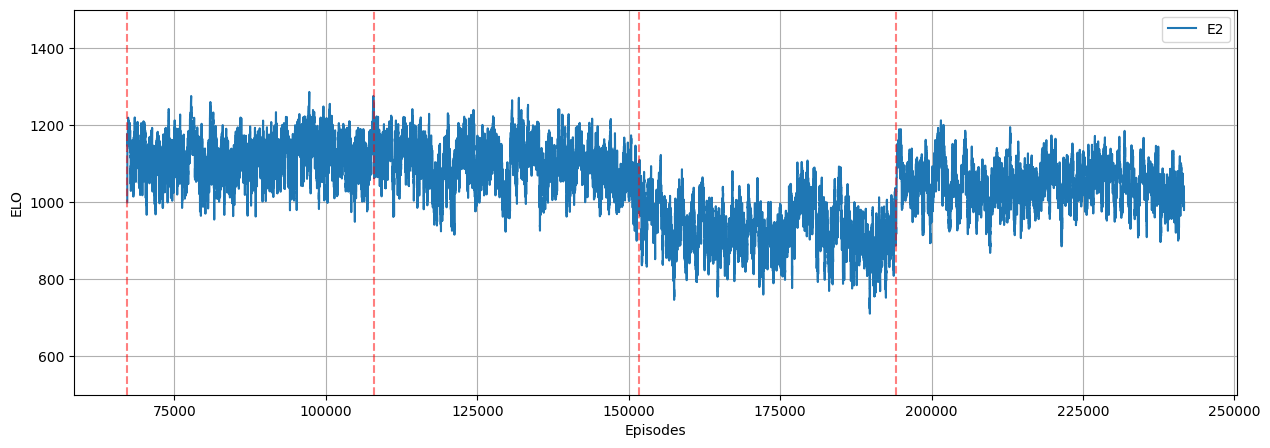

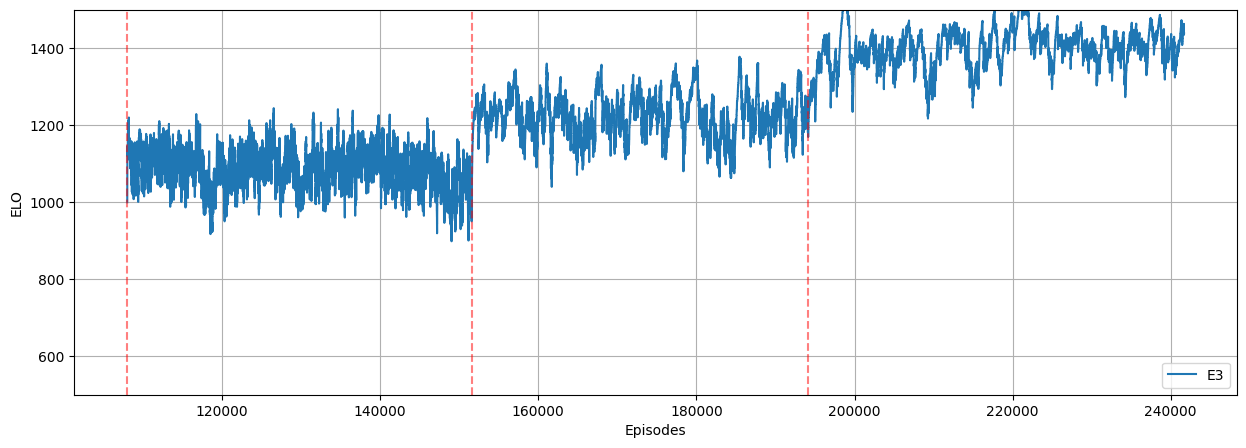

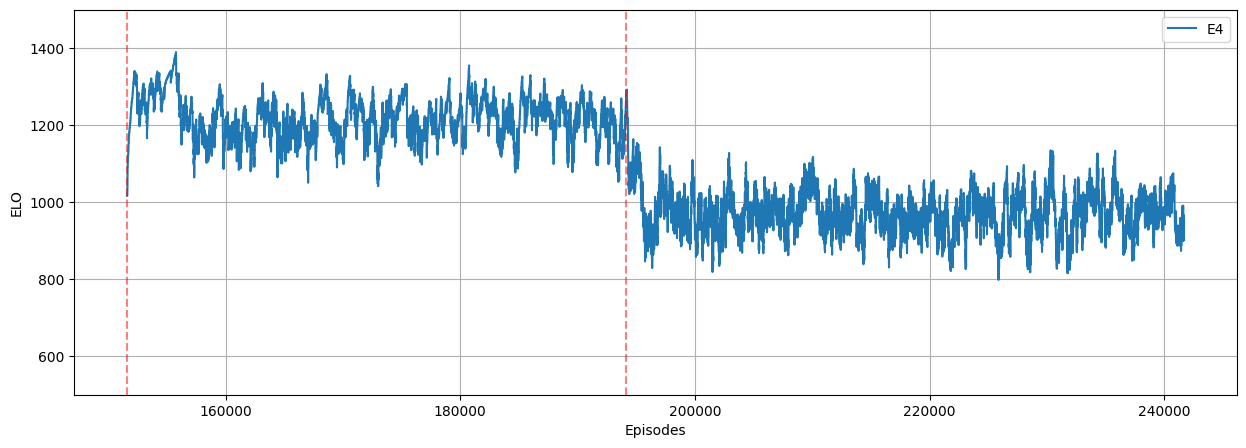

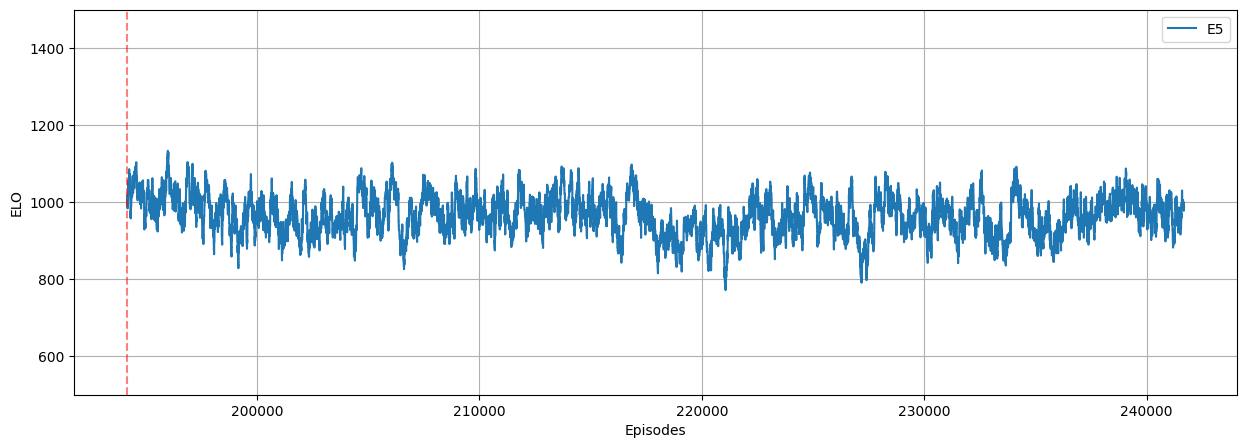

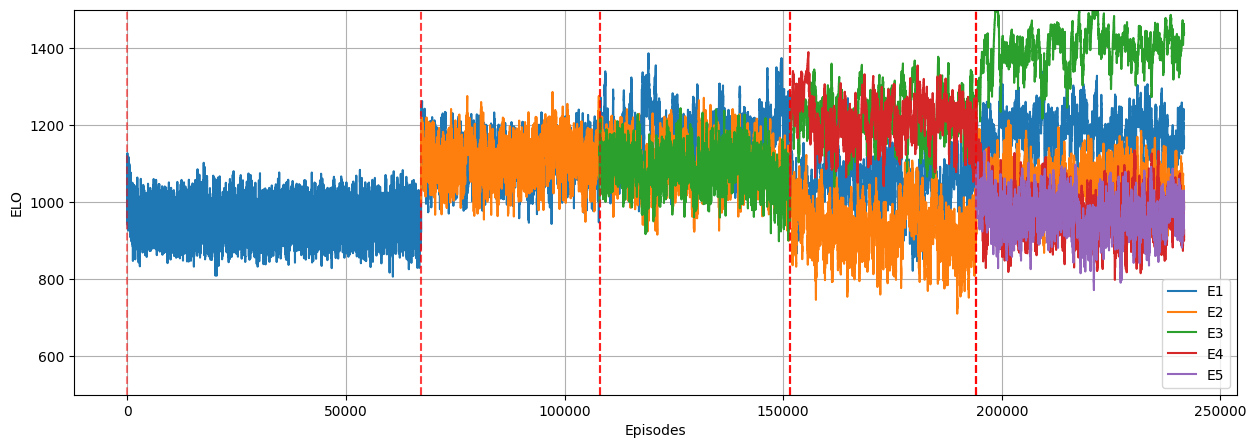

In [5]:
min_model = 1
max_model = 5
print(cum_eps_ego[-0])

for i in range(min_model, max_model + 1):
    plt.figure(figsize=(15, 5))
    plt.plot(
        range(cum_eps_ego[-(max_ego_version + 2 - i)], cum_eps_ego[-1]),
        npc_elos[i - 1, cum_eps_ego[-(max_ego_version + 2 - i)] :],
        label=f"V{i}",
    )
    # plt.plot(range(cum_eps_ego[-(max_ego_version+2-i)],cum_eps_ego[-1]),opponent_ego_elos[i-1,cum_eps_ego[-(max_ego_version+2-i)]:], label=f"V{i} Opponent")
    for j in range(i, max_ego_version + 1):
        plt.axvline(x=cum_eps_ego[j - 1], color="r", linestyle="--", alpha=0.5)
    plt.xlabel("Episodes")
    plt.ylabel("ELO")
    plt.legend()
    plt.grid()
    plt.show()

plt.figure(figsize=(15, 5))
for i in range(min_model, max_model + 1):
    plt.plot(
        range(cum_eps_ego[-(max_ego_version + 2 - i)], cum_eps_ego[-1]),
        npc_elos[i - 1, cum_eps_ego[-(max_ego_version + 2 - i)] :],
        label=f"V{i}",
    )
    # plt.plot(range(cum_eps_ego[-(max_ego_version+2-i)],cum_eps_ego[-1]),opponent_ego_elos[i-1,cum_eps_ego[-(max_ego_version+2-i)]:], label=f"V{i} Opponent")
    for j in range(i, max_ego_version + 1):
        plt.axvline(x=cum_eps_ego[j - 1], color="r", linestyle="--", alpha=0.5)
plt.xlabel("Episodes")
plt.ylabel("ELO")
plt.legend()
plt.grid()
plt.show()

for i in range(min_model, max_model + 1):
    plt.figure(figsize=(15, 5))
    plt.plot(
        range(cum_eps_npc[-(max_npc_version + 2 - i)], cum_eps_npc[-1]),
        ego_elos[i - 1, cum_eps_npc[-(max_npc_version + 2 - i)] :],
        label=f"E{i}",
    )
    # plt.plot(range(cum_eps_npc[-(max_npc_version+2-i)],cum_eps_npc[-1]),opponent_npc_elos[i-1,cum_eps_npc[-(max_npc_version+2-i)]:], label=f"E{i} Opponent")
    for j in range(i, max_npc_version + 1):
        plt.axvline(x=cum_eps_npc[j - 1], color="r", linestyle="--", alpha=0.5)
    plt.xlabel("Episodes")
    plt.ylabel("ELO")
    plt.ylim(500, 1500)
    plt.legend()
    plt.grid()
    plt.show()

plt.figure(figsize=(15, 5))
for i in range(min_model, max_model + 1):
    plt.plot(
        range(cum_eps_npc[-(max_npc_version + 2 - i)], cum_eps_npc[-1]),
        ego_elos[i - 1, cum_eps_npc[-(max_npc_version + 2 - i)] :],
        label=f"E{i}",
    )
    # plt.plot(range(cum_eps_npc[-(max_npc_version+2-i)],cum_eps_npc[-1]),opponent_npc_elos[i-1,cum_eps_npc[-(max_npc_version+2-i)]:], label=f"E{i} Opponent")
    for j in range(i, max_npc_version + 1):
        plt.axvline(x=cum_eps_npc[j - 1], color="r", linestyle="--", alpha=0.5)
plt.xlabel("Episodes")
plt.ylabel("ELO")
plt.ylim(500, 1500)
plt.legend()
plt.grid()
plt.show()